# Fighting Fire with Data - Starter Notebook

This notebook should help you get started with the 'Fighting Fire with Data' hackathon on Zindi. In it we cover:
- Loading the data
- Simple EDA and an example of feature engineering
- Suggestions for validation split
- Creating a simple model
- Making a submission
- Some tips for improving your score


# Setup

Make sure the files are available in the current directory. On Colab, upload them using the files tab on the left.

In [1]:
!ls data/*.csv # List files to check train, ss and test are present

data/SampleSubmission.csv  data/Train.csv
data/Test.csv		   data/variable_definitions.csv


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from matplotlib import pyplot as plt

In [3]:
# The training data.
var_defs = pd.read_csv('data/variable_definitions.csv')
var_defs

,Variable,Description
0,ID,The IDs take the form of [area ID]_yyyy-mm-dd....
1,area,Area ID
2,date,The date that the data is aggregated over
3,lat,Latitude of the center of the area
4,lon,Longitude of the center of the area
5,burn_area,Percentage of the area burnt
6,climate_aet,"Actual evapotranspiration, derived using a one..."
7,climate_def,"Climate water deficit, derived using a one-dim..."
8,climate_pdsi,Palmer Drought Severity Index
9,climate_pet,Reference evapotranspiration (ASCE Penman-Mont...


In [4]:
# The training data.
train = pd.read_csv('data/Train.csv')
train.head()

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,...,0.0,0.0,0.018654,0.0,0.714446,0.012174,0.244890,0.009836,0.0,0.256932
1,1_2001-01-01,-15.858835,29.487029,0.0,1196,0,232,1196,201,10,...,0.0,0.0,0.000000,0.0,0.654783,0.000095,0.345121,0.000000,0.0,0.273093
2,2_2001-01-01,-15.858835,29.737029,0.0,1190,0,314,1190,192,10,...,0.0,0.0,0.000000,0.0,0.516421,0.000000,0.483579,0.000000,0.0,0.285109
3,3_2001-01-01,-15.858835,29.987029,0.0,1144,0,321,1144,186,66,...,0.0,0.0,0.000000,0.0,0.299000,0.163902,0.537098,0.000000,0.0,0.298418
4,4_2001-01-01,-15.858835,30.237029,0.0,1187,0,413,1187,186,9,...,0.0,0.0,0.000000,0.0,0.277392,0.067742,0.654866,0.000000,0.0,0.315621


In [5]:
# The test set - notice there is no 'burn_area' column.
test = pd.read_csv('data/Test.csv')
test.head(1)

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,...,0.0,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243


# EDA + Feature Engineering

In [6]:
# Look at distribution of each variable
train.describe()

,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
count,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,...,83148.000000,83148.000000,83148.000000,8.314800e+04,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000
mean,-19.014557,29.860856,0.007632,484.491124,828.892721,-30.806237,1313.382992,54.576322,6.215134,305.477919,...,0.006158,0.000017,0.008583,4.066313e-08,0.160628,0.037453,0.785382,0.000354,0.001424,0.078551
std,1.588444,1.751090,0.029226,470.467480,546.934469,235.802930,315.209838,71.997561,21.480399,400.956123,...,0.053111,0.000141,0.059046,3.535121e-06,0.192957,0.106050,0.233953,0.001773,0.014233,0.104464
min,-22.358835,25.487029,0.000000,0.000000,0.000000,-563.000000,587.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000
25%,-20.358835,28.487029,0.000000,50.000000,375.000000,-212.000000,1081.000000,1.000000,0.000000,70.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.014993,0.000000,0.655322,0.000000,0.000000,0.002017
50%,-18.858835,29.987029,0.000000,302.000000,858.000000,-108.000000,1290.000000,22.000000,1.000000,149.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.076706,0.000139,0.880600,0.000000,0.000000,0.028503
75%,-17.858835,31.237029,0.000000,931.000000,1211.000000,142.000000,1517.000000,87.000000,4.000000,329.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.246498,0.015166,0.971209,0.000000,0.000000,0.125500
max,-15.858835,32.987029,0.843886,1713.000000,2614.000000,851.000000,2620.000000,501.000000,342.000000,3319.000000,...,0.828131,0.004918,0.711603,3.073689e-04,0.981472,0.881323,1.000000,0.016708,0.301823,0.801328


<Axes: >

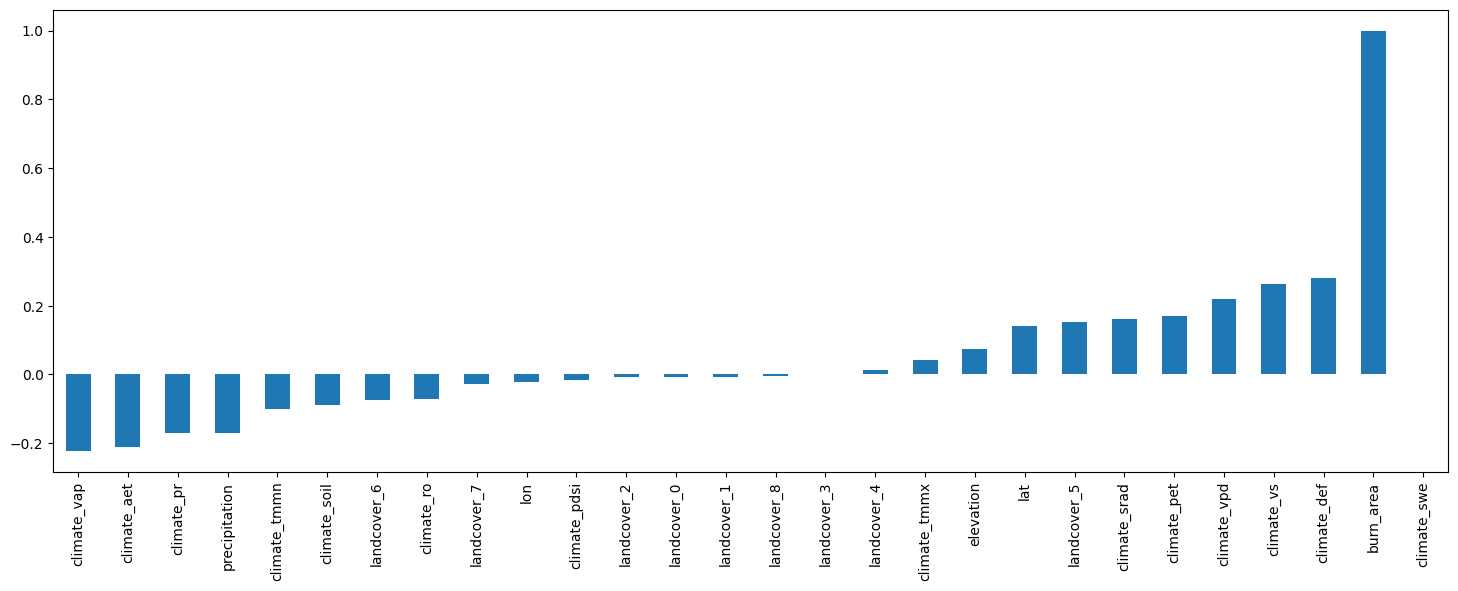

In [7]:
# Look at correlation with target
train.select_dtypes(include=['number']).corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

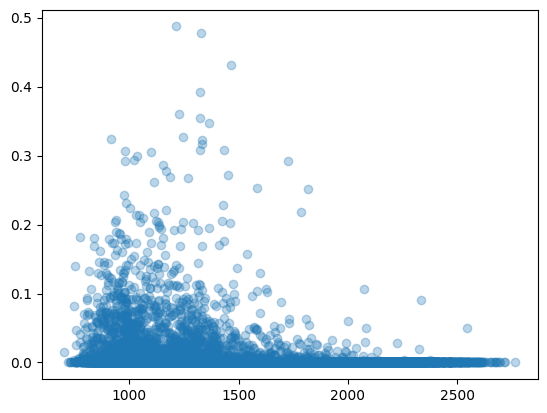

In [8]:
# Look at some scatter plots (only plotting for a subset of data to keep things fast)
sample = train.sample(10000)
plt.scatter(sample['climate_vap'], sample['burn_area'], alpha=0.3)

Text(0, 0.5, 'Burn Area')

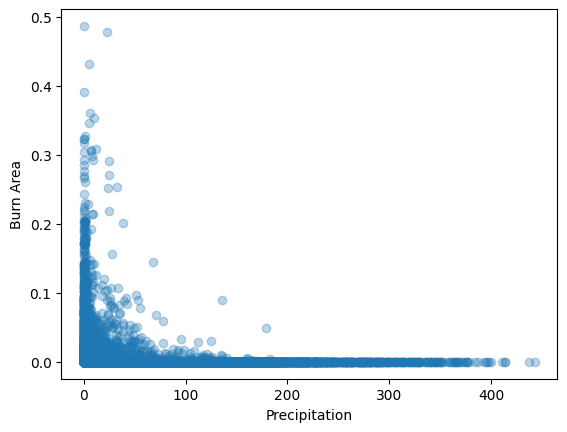

In [9]:
# Most fires occur when there's very little rain.
plt.scatter(sample['climate_pr'], sample['burn_area'], alpha=0.3)
plt.xlabel('Precipitation')
plt.ylabel('Burn Area')

##  Adding date features

In [10]:
# Split the ID (eg 127_2017-01-03) to get the date string, which we convert to datetime to make life easier
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))

In [11]:
train['date'][1]

Timestamp('2001-01-01 00:00:00')

In [12]:
train.head()

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,...,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation,date
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,...,0.0,0.018654,0.0,0.714446,0.012174,0.244890,0.009836,0.0,0.256932,2001-01-01
1,1_2001-01-01,-15.858835,29.487029,0.0,1196,0,232,1196,201,10,...,0.0,0.000000,0.0,0.654783,0.000095,0.345121,0.000000,0.0,0.273093,2001-01-01
2,2_2001-01-01,-15.858835,29.737029,0.0,1190,0,314,1190,192,10,...,0.0,0.000000,0.0,0.516421,0.000000,0.483579,0.000000,0.0,0.285109,2001-01-01
3,3_2001-01-01,-15.858835,29.987029,0.0,1144,0,321,1144,186,66,...,0.0,0.000000,0.0,0.299000,0.163902,0.537098,0.000000,0.0,0.298418,2001-01-01
4,4_2001-01-01,-15.858835,30.237029,0.0,1187,0,413,1187,186,9,...,0.0,0.000000,0.0,0.277392,0.067742,0.654866,0.000000,0.0,0.315621,2001-01-01


In [13]:
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

In [14]:
# Group by month and calculate the mean burn_area
monthly_mean_burn_area = train.groupby('month')['burn_area'].mean().reset_index()

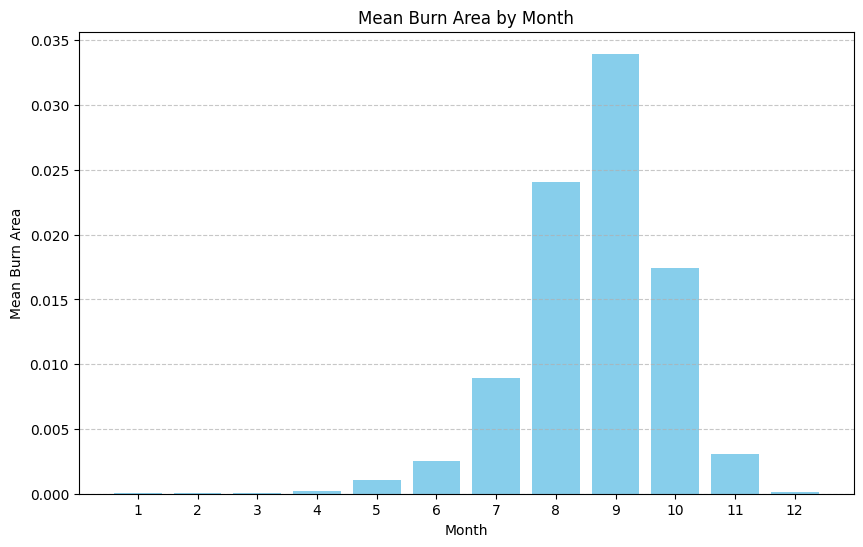

In [15]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(monthly_mean_burn_area['month'], monthly_mean_burn_area['burn_area'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Mean Burn Area')
plt.title('Mean Burn Area by Month')
plt.xticks(monthly_mean_burn_area['month'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [16]:
# Group by year and calculate the mean burn_area
yearly_mean_burn_area = train.groupby('year')['burn_area'].mean().reset_index()

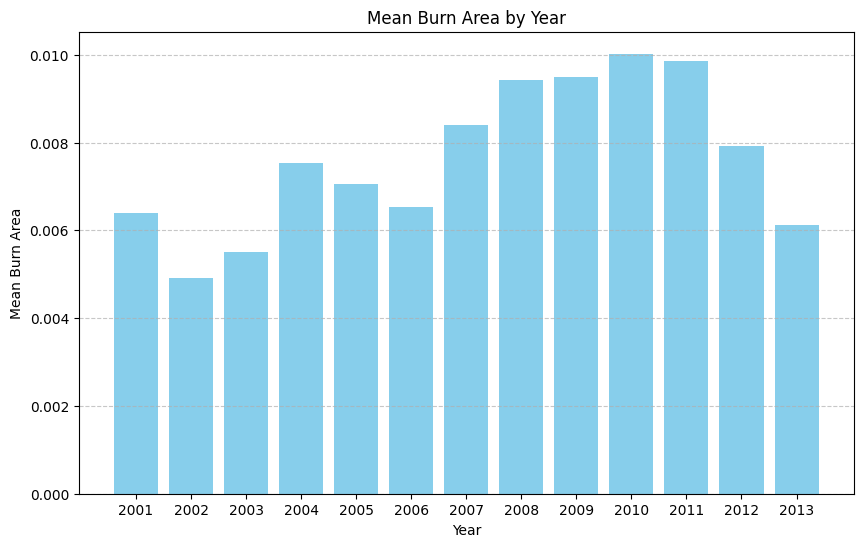

In [17]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(yearly_mean_burn_area['year'], yearly_mean_burn_area['burn_area'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Mean Burn Area')
plt.title('Mean Burn Area by Year')
plt.xticks(yearly_mean_burn_area['year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Axes: xlabel='date'>

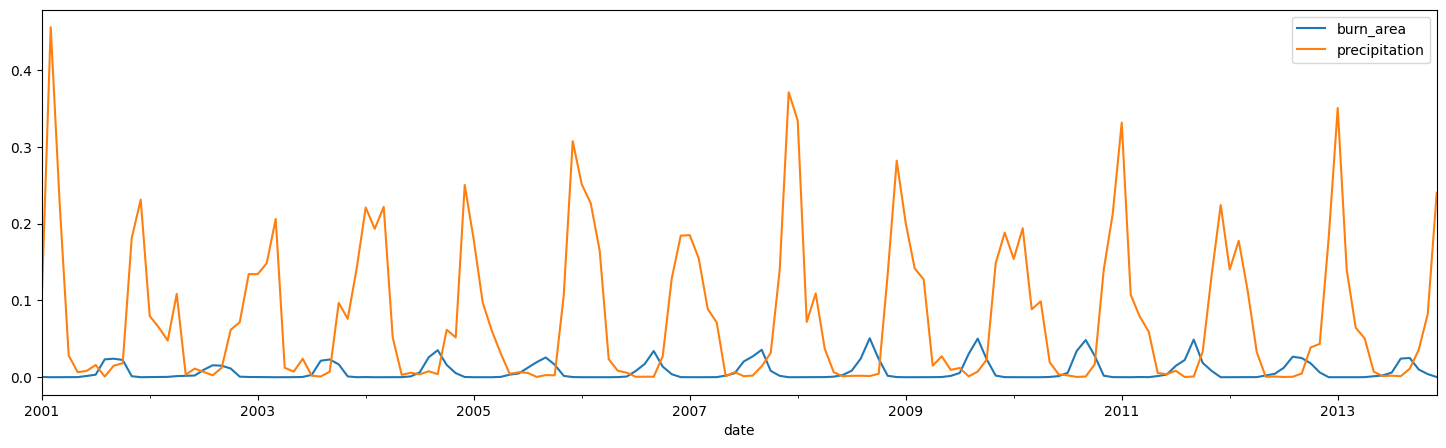

In [18]:
# Convert 'burn_area' to numeric, handling non-numeric values
train['burn_area'] = pd.to_numeric(train['burn_area'], errors='coerce')

# Now try plotting again
ax = train.groupby('date')['burn_area'].mean().reset_index().plot(y='burn_area', x='date', figsize=(18, 5))
train.groupby('date')['precipitation'].mean().reset_index().plot(y='precipitation', x='date', ax=ax)

## Adding more features - some ideas




*   Read the list of climate variables and what they mean. See if you can combine them in interesting ways - perhaps a 'hot_and_dry' metric...
*   Fire depends on some processes that take a long time - for example, there may be more fuel if the previous growing season was a good one. Consider some lagged variables to give the model some inputs for what came before the current month.
*   Make some categorical features - 'dominant_land_type' or 'is_peak_rainfall'.
*   ...



In [19]:
# Calculate the hot_and_dry metric
train['hot_and_dry'] = (train['climate_tmmx'] / train['climate_tmmx'].max()) + (1 - (train['climate_pr'] / train['climate_pr'].max()))
# Scale the metric to a range of 0 to 1
train['hot_and_dry'] = train['hot_and_dry'] / train['hot_and_dry'].max()

In [20]:
# Create lagged variables for climate_tmmx and climate_pr
train.loc[:, 'climate_tmmx_lag1'] = train.loc[:, 'climate_tmmx'].shift(1)
train.loc[:, 'climate_tmmx_lag2'] = train.loc[:, 'climate_tmmx'].shift(2)
train.loc[:, 'climate_tmmx_lag3'] = train.loc[:, 'climate_tmmx'].shift(3)

train.loc[:, 'climate_pr_lag1'] = train.loc[:, 'climate_pr'].shift(1)
train.loc[:, 'climate_pr_lag2'] = train.loc[:, 'climate_pr'].shift(2)
train.loc[:, 'climate_pr_lag3'] = train.loc[:, 'climate_pr'].shift(3)

In [21]:
# Create a categorical feature for dominant land type
landcover_cols = [f'landcover_{i}' for i in range(9)]
train.loc[:, 'dominant_land_type'] = train[landcover_cols].idxmax(axis=1)

In [22]:
train['is_peak_rainfall'] = np.where(train['precipitation'] < 0.2, 'Low', np.where(train['precipitation'] < 0.4, 'Moderate', np.where(train['precipitation'] < 0.6, 'High', 'Very High')))

In [23]:
le = LabelEncoder()
train['dominant_land_type'] = le.fit_transform(train['dominant_land_type'])
train['is_peak_rainfall'] = le.fit_transform(train['is_peak_rainfall'])

In [24]:
train.head(5)

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,...,year,hot_and_dry,climate_tmmx_lag1,climate_tmmx_lag2,climate_tmmx_lag3,climate_pr_lag1,climate_pr_lag2,climate_pr_lag3,dominant_land_type,is_peak_rainfall
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,...,2001,0.690661,NaN,NaN,NaN,NaN,NaN,NaN,2,2
1,1_2001-01-01,-15.858835,29.487029,0.0,1196,0,232,1196,201,10,...,2001,0.696901,317.0,NaN,NaN,206.0,NaN,NaN,2,2
2,2_2001-01-01,-15.858835,29.737029,0.0,1190,0,314,1190,192,10,...,2001,0.704633,318.0,317.0,NaN,201.0,206.0,NaN,2,2
3,3_2001-01-01,-15.858835,29.987029,0.0,1144,0,321,1144,186,66,...,2001,0.693121,317.0,318.0,317.0,192.0,201.0,206.0,4,2
4,4_2001-01-01,-15.858835,30.237029,0.0,1187,0,413,1187,186,9,...,2001,0.706871,303.0,317.0,318.0,186.0,192.0,201.0,4,2


# Data Split for Validation

We don't want to just split randomly - this would give us artificially high scores. Instead, let's use the last 3 years of the dataset for validation to more closely match the test configuration.

In [25]:
train_all = train.copy().dropna()
train = train_all.loc[train_all.date < '2011-01-01']
valid = train_all.loc[train_all.date > '2011-01-01']
print(train.shape, valid.shape)

(63957, 41) (18655, 41)


# Simple Model

In [26]:
train_all.columns

Index(['ID', 'lat', 'lon', 'burn_area', 'climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation', 'date', 'month', 'year', 'hot_and_dry',
       'climate_tmmx_lag1', 'climate_tmmx_lag2', 'climate_tmmx_lag3',
       'climate_pr_lag1', 'climate_pr_lag2', 'climate_pr_lag3',
       'dominant_land_type', 'is_peak_rainfall'],
      dtype='object')

In [27]:
# Define input and output columns - you can play with adding or removing inputs to the model
in_cols = ['climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation', 'hot_and_dry', 'climate_tmmx_lag1', 'climate_tmmx_lag2', 'climate_tmmx_lag3',
       'climate_pr_lag1', 'climate_pr_lag2', 'climate_pr_lag3', 'dominant_land_type', 'is_peak_rainfall']
target_col = 'burn_area'

In [28]:
# Get our X and y training and validation sets ready
X_train, y_train = train[in_cols], train[target_col]
X_valid, y_valid = valid[in_cols], valid[target_col]

# Create and fit the model
model = RidgeCV()
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_valid)

# Score
mean_squared_error(y_valid, preds)**0.5 # RMSE - should match Zindi score. Lower is better

np.float64(0.02715023392304356)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train[in_cols], train[target_col], test_size=0.2, random_state=42)

# Define the list of max_depth values to experiment with
max_depth_values = [3, 5, 7, 10, 15, 20, 25]

# Initialize an empty list to store the scores for each max_depth value
scores = []

# Loop over the max_depth values and train a RandomForestRegressor model for each value
for max_depth in max_depth_values:
    model = RandomForestRegressor(n_estimators=10, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    scores.append(score)

# Find the max_depth value with the lowest score
best_max_depth = max_depth_values[scores.index(min(scores))]

# Train a RandomForestRegressor model with the best max_depth value
model = RandomForestRegressor(n_estimators=10, max_depth=best_max_depth, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {score}")
print(f"r2_score: {r2}")
print(f"Root mean squared error: {rmse}")

Mean Squared Error: 0.0005512809277510497
r2_score: 0.34378479181627397
Root mean squared error: 0.02315665677101777


# Making A Submission

Once you've got some features and a model you're happy with, it's time to submit!

In [30]:
# Look at the sample submission file
ss = pd.read_csv('data/SampleSubmission.csv')
ss.head()

,ID,burn_area
0,0_2014-01-01,0
1,1_2014-01-01,0
2,2_2014-01-01,0
3,3_2014-01-01,0
4,4_2014-01-01,0


In [31]:
# And the test data
test.head()

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation,date
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,...,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243,2014-01-01
1,1_2014-01-01,-15.858835,29.487029,1118,98,-405,1216,117,6,330,...,0.000000,0.000000,0.0,0.406436,0.000446,0.593118,0.000000,0.0,0.421489,2014-01-01
2,2_2014-01-01,-15.858835,29.737029,1067,137,-468,1204,111,6,194,...,0.000000,0.000000,0.0,0.254791,0.000000,0.745209,0.000000,0.0,0.419122,2014-01-01
3,3_2014-01-01,-15.858835,29.987029,969,187,-533,1156,101,5,78,...,0.000000,0.000000,0.0,0.219340,0.182153,0.598507,0.000000,0.0,0.404596,2014-01-01
4,4_2014-01-01,-15.858835,30.237029,927,270,-505,1197,96,5,139,...,0.000000,0.000000,0.0,0.220239,0.097748,0.682013,0.000000,0.0,0.371100,2014-01-01


In [32]:
# So we need to predict the burn area for each row in test.

# Add the same features to test as we did to train:
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['hot_and_dry'] = (test['climate_tmmx'] / test['climate_tmmx'].max()) + (1 - (test['climate_pr'] / test['climate_pr'].max()))
test['hot_and_dry'] = test['hot_and_dry'] / test['hot_and_dry'].max()
test.loc[:, 'climate_tmmx_lag1'] = test.loc[:, 'climate_tmmx'].shift(1)
test.loc[:, 'climate_tmmx_lag2'] = test.loc[:, 'climate_tmmx'].shift(2)
test.loc[:, 'climate_tmmx_lag3'] = test.loc[:, 'climate_tmmx'].shift(3)
test.loc[:, 'climate_pr_lag1'] = test.loc[:, 'climate_pr'].shift(1)
test.loc[:, 'climate_pr_lag2'] = test.loc[:, 'climate_pr'].shift(2)
test.loc[:, 'climate_pr_lag3'] = test.loc[:, 'climate_pr'].shift(3)
test.loc[:, 'dominant_land_type'] = test[landcover_cols].idxmax(axis=1)
test.loc[:, 'is_peak_rainfall'] = test['precipitation'] > test['precipitation'].mean()

landcover_cols = [f'landcover_{i}' for i in range(9)]
test.loc[:, 'dominant_land_type'] = test[landcover_cols].idxmax(axis=1)

test['is_peak_rainfall'] = np.where(test['precipitation'] < 0.2, 'Low', np.where(test['precipitation'] < 0.4, 'Moderate', np.where(test['precipitation'] < 0.6, 'High', 'Very High')))

test['dominant_land_type'] = le.fit_transform(test['dominant_land_type'])
test['is_peak_rainfall'] = le.fit_transform(test['is_peak_rainfall'])

# Get predictions
preds = model.predict(test[in_cols].fillna(0)) # fillna(0) here could be improved by examining the missing data and filling more appropriately.

# Add to submission dataframe
ss['burn_area'] = preds

# Depending on your model, you may have some predictions that don't make sense. Let's constrain our predictions to the range (0, 1)
ss['burn_area'] = ss['burn_area'].clip(0, 1)

# View
ss.head()

,ID,burn_area
0,0_2014-01-01,0.058958
1,1_2014-01-01,0.091948
2,2_2014-01-01,0.123018
3,3_2014-01-01,0.000733
4,4_2014-01-01,0.000606


In [33]:
# Save ready for submission:
ss.to_csv('starter_submission.csv', index=False)

# Tips for improving your score

- Once you've chosen a model, you should re-train it on all the data (including that which you previously held back for validation) to give it the best chance of succeeding
- There is a timeseries component to this challenge. Think about how to use this to improve your accuracy.
- Spend some time on feature engineering. Since no external data is allowed for this challenge, the winning solution will be the one that gets the most out of the data provided.